In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import maxabs_scale
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = '100k/'
userdf = pd.read_csv(path+'u.user',delimiter='|',header=None,engine='python')
ratedf = pd.read_csv(path+'u.data',delimiter='\t',header=None,engine='python')
moviedf = pd.read_csv(path+'u.item',index_col=0,delimiter='|',header=None,engine='python')

In [3]:
traindf = pd.read_csv(path+'ua.base',delimiter='\t',header=None,engine='python')
testdf = pd.read_csv(path+'ua.test',delimiter='\t',header=None,engine='python')

In [4]:
print len(traindf),len(testdf)

90570 9430


In [5]:
moviedf.head()

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
0,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


495 1
737 20


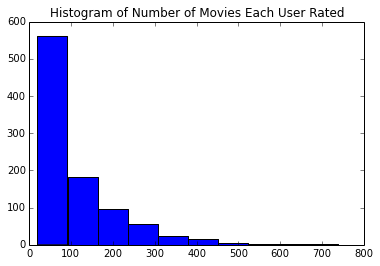

In [6]:
count = traindf.groupby(1).size().values
print max(count),min(count)
count = ratedf.groupby(0).size().values
print max(count),min(count)
plt.hist(count)
plt.title('Histogram of Number of Movies Each User Rated')
plt.show()

In [7]:
# global average
global_av = np.mean(traindf[2])
global_pred = np.zeros(len(testdf))
global_pred.fill(global_av)
user_pred = np.zeros(len(testdf))
movie_pred = np.zeros(len(testdf))
bias_pred = np.zeros(len(testdf))

In [8]:
# user rating average
user_av = traindf[2].groupby(traindf[0]).mean()
# # group rating by user  ID
user_gb = traindf.groupby(0)
# # movie rating average
movie_av =  traindf[2].groupby(traindf[1]).mean()

# group rating by movie
movie_gb = traindf.groupby(1)
# true rating
test_y = testdf[2]
movies = set(traindf[1])
for i,row in testdf.iterrows():
    userid = row[0]
    movieid = row[1]
    user_pred[i] = user_av[userid]
    user_bias = user_av[userid]-global_av
    if movieid in movies:
        movie_pred[i] = movie_av[movieid]
        movie_bias = movie_av[movieid]-global_av
    else:
        movie_pred[i] = global_av
        movie_bias = 0
    bias_pred[i] = global_av + user_bias +movie_bias


In [9]:
print 'Global Average',np.sqrt(mean_squared_error(test_y,global_pred))
print 'User Average',np.sqrt(mean_squared_error(test_y,user_pred))
print 'Item Average',np.sqrt(mean_squared_error(test_y,movie_pred))
print 'UserItem Average',np.sqrt(mean_squared_error(test_y,bias_pred))

Global Average 1.1220056791
User Average 1.0431349636
Item Average 1.04176479694
UserItem Average 0.991903770998


In [10]:
m = pd.DataFrame(index=np.arange(1682)+1,columns=np.arange(943)+1)
# m = pd.DataFrame(columns=np.arange(1682)+1,index=np.arange(943)+1)
for item in traindf.iterrows():
    item = item[1]
    m[item[0]].loc[item[1]]=item[2]
m = m.fillna(0)
print m.head()
m = np.array(m,dtype=float)

   1    2    3    4    5    6    7    8    9    10  ...   934  935  936  937  \
1    5    4    0    0    0    4    0    0    0    4 ...     2    3    4    0   
2    3    0    0    0    0    0    0    0    0    0 ...     4    0    0    0   
3    4    0    0    0    0    0    0    0    0    0 ...     0    0    4    0   
4    3    0    0    0    0    0    5    0    0    4 ...     5    0    0    0   
5    3    0    0    0    0    0    0    0    0    0 ...     0    0    0    0   

   938  939  940  941  942  943  
1    4    0    0    5    0    0  
2    0    0    0    0    0    5  
3    0    0    0    0    0    0  
4    0    0    2    0    0    0  
5    0    0    0    0    0    0  

[5 rows x 943 columns]


In [11]:
item_unknn = np.zeros(len(testdf))
item_wknn = np.zeros(len(testdf))
user_pr_unknn = np.zeros(len(testdf))
user_pr_wknn = np.zeros(len(testdf))
user_cos_unknn = np.zeros(len(testdf))
user_cos_wknn = np.zeros(len(testdf))
user_adj_unknn = np.zeros(len(testdf))
user_adj_wknn = np.zeros(len(testdf))

In [12]:
# Item-based KNN(Cosine similarity)
item_unknn_rmse = np.zeros(11)
item_wknn_rmse = np.zeros(11)
cos_item = cosine_similarity(m)
# Replace zero similarity with a small similarity
cos_item[cos_item==0]=0.01
print 'k Weighted \t','Unweighted'
for i,k in enumerate([3,5,10,20,25,50,80,100,200,300,400]):
    for j,item in enumerate(testdf.iterrows()):
        item = item[1]
        # movieid
        movie = item[1]-1
        # userid
        user = item[0]-1
        # user rating
        y = m[:,user]
        index = np.nonzero(y)
        y = y[index]
        sim = cos_item[movie][index]
        top_k = sim.argsort()[-k:]
        # Unweighted
        item_unknn[j]=np.sum(y[top_k])/len(top_k)
        # Weighted Average
        item_wknn[j]=np.dot(y[top_k],sim[top_k])/np.sum(np.absolute(sim[top_k]))
    item_unknn_rmse[i] = np.sqrt(mean_squared_error(test_y,item_unknn))
    item_wknn_rmse[i] = np.sqrt(mean_squared_error(test_y,item_wknn))
    print k,item_unknn_rmse[i],item_wknn_rmse[i]

k Weighted 	Unweighted
3 1.05918305331 1.05735047017
5 1.02625140225 1.02320424257
10 1.00513474931 1.00004972183
20 1.00681798725 0.997621702043
25 1.01123122648 1.00033205456
50 1.02264412648 1.00806743251
80 1.02961044815 1.01269673081
100 1.03321768443 1.01476067994
200 1.04083988277 1.01858497771
300 1.04255242388 1.01928240746
400 1.04311932846 1.01945760457


In [55]:
# reshape warning
from scipy.spatial.distance import correlation
import warnings
warnings.filterwarnings('ignore')
    
# pearson correlation
def cor(x,y,i,j,f):
    index = np.nonzero(x*y)[0]
    if i==j: return 1
    if len(index)<4: return 0.001
    if f=='cor':
        x_mean = user_av[i+1]
        y_mean = user_av[j+1]
        return cosine_similarity(x[index]-x_mean,y[index]-y_mean)
    if f=='adj':
        x1 = x[index]-movie_av[index+1]
        y1 = y[index]-movie_av[index+1]
        return cosine_similarity(x1,y1)
# Build Similarity Matrix
def sim_matrix(matrix,f):
    size = len(matrix)
    simil = np.zeros((size,size))
    for i in range(size):
        for j in range(i,size):
            result = cor(matrix[i],matrix[j],i,j,f)
            simil[i][j]=result
            simil[j][i]=result
    return simil

In [56]:
# User-based Rating matrix
user_m = m.T

In [60]:
# User-based KNN(Pearson Correlation)
user_adj1_rmse = np.zeros(11)
user_adj2_rmse = np.zeros(11)
pearson_user = sim_matrix(user_m,'cor')
for i,k in enumerate([3,5,10,20,25,50,80,100,200,300,500]):
    for j,item in enumerate(testdf.iterrows()):
        item = item[1]
        # movieid
        movie = item[1]-1
        # userid
        user = item[0]-1
        # user rating
        y = user_m[:,movie]
        index = np.nonzero(y)[0]
        if len(index)==0: 
            user_adj_unknn[j]=global_av
            user_adj_wknn[j]=global_av
            continue
        y = y[index]
        sim = pearson_user[user][index]
        top_k = sim.argsort()[-k:]
        user_adj_unknn[j]=np.sum(y[top_k])/len(top_k)
        user_adj_wknn[j]=np.dot(y[top_k]-user_av[top_k+1],sim[top_k])/np.sum(np.absolute(sim[top_k]))+user_av[user+1]
    user_adj1_rmse[i] = np.sqrt(mean_squared_error(test_y,user_adj_unknn))
    user_adj2_rmse[i] = np.sqrt(mean_squared_error(test_y,user_adj_wknn))
    print k,user_adj1_rmse[i],user_adj2_rmse[i]

3 1.13691001492 1.13476123779
5 1.08115396035 1.06640341404
10 1.04660248483 1.01743461343
20 1.02990086635 0.993997268104
25 1.02826335356 0.989803186322
50 1.02713810247 0.981172526374
80 1.03019358819 0.978722699294
100 1.03172373185 0.979066620173
200 1.03844061227 0.977246869341
300 1.04064708586 0.976708326257
500 1.04176479694 0.976508911263


In [80]:
# User-based KNN(Adjusted Cosine)
user_adj1_rmse = np.zeros(11)
user_adj2_rmse = np.zeros(11)
adj_user = sim_matrix(user_m,'adj')
for i,k in enumerate([3,5,10,20,25,50,80,100,200,300,500]):
    for j,item in enumerate(testdf.iterrows()):
        item = item[1]
        # movieid
        movie = item[1]-1
        # userid
        user = item[0]-1
        # user rating
        y = user_m[:,movie]
        index = np.nonzero(y)[0]
        if len(index)==0: 
            user_adj_unknn[j]=global_av
            user_adj_wknn[j]=global_av
            continue
        y = y[index]
        sim = adj_user[user][index]
        top_k = sim.argsort()[-k:]
        user_adj_unknn[j]=np.sum(y[top_k])/len(top_k)
        y = y[top_k]
        sim = sim[top_k]
        top_k = np.where(sim>0)[0]
        if len(top_k)==0:
            user_adj_unknn[j]=global_av
            user_adj_wknn[j]=global_av
            continue
        user_adj_wknn[j]=np.dot(y[top_k],sim[top_k])/np.sum(np.absolute(sim[top_k]))
    user_adj1_rmse[i] = np.sqrt(mean_squared_error(test_y,user_adj_unknn))
    user_adj2_rmse[i] = np.sqrt(mean_squared_error(test_y,user_adj_wknn))
    print k,user_adj1_rmse[i],user_adj2_rmse[i]

3 1.0936504603 1.10057103914
5 1.03356931945 1.04047479436
10 0.987856944827 0.993733962453
20 0.977603978589 0.97681648262
25 0.978745756561 0.975437138337
50 0.990734872826 0.973418346958
80 1.00370764684 0.97425070068
100 1.01068609558 0.974607842414
200 1.03119937384 0.975071650398
300 1.03759075652 0.975082789574
500 1.03990845165 0.975084717165


In [83]:
# User-based KNN(Pearson Correlation)
user_unknn_rmse = np.zeros(11)
user_wknn_rmse = np.zeros(11)
cos_user = cosine_similarity(user_m)
cos_user[cos_user==0]=0.01
# Replace zero similarity with a small similarity
for i,k in enumerate([3,5,10,20,25,50,80,100,200,300,500]):
    for j,item in enumerate(testdf.iterrows()):
        item = item[1]
        # movieid
        movie = item[1]-1
        # userid
        user = item[0]-1
        # user rating
        y = user_m[:,movie]
        index = np.nonzero(y)[0]
        if len(index)==0: 
            user_cos_unknn[j]=global_av
            user_cos_wknn[j]=global_av
            continue
        y = y[index]
        sim = cos_user[user][index]
        top_k = sim.argsort()[-k:]
        user_cos_unknn[j]=np.sum(y[top_k])/len(top_k)
        user_cos_wknn[j]=np.dot(y[top_k],sim[top_k])/np.sum(np.absolute(sim[top_k]))
        
    user_unknn_rmse[i] = np.sqrt(mean_squared_error(test_y,user_cos_unknn))
    user_wknn_rmse[i] = np.sqrt(mean_squared_error(test_y,user_cos_wknn))
    print k,user_unknn_rmse[i],user_wknn_rmse[i]

3 1.13465883803 1.13469687729
5 1.08379313788 1.08335985176
10 1.0482871379 1.04773119809
20 1.03270004813 1.03192226158
25 1.03059894115 1.02944060184
50 1.02843304435 1.02653268425
80 1.03232780077 1.02905000012
100 1.03458751413 1.0305999686
200 1.03911806588 1.03350120415
300 1.04097317994 1.03440336455
500 1.04176479694 1.03468914071


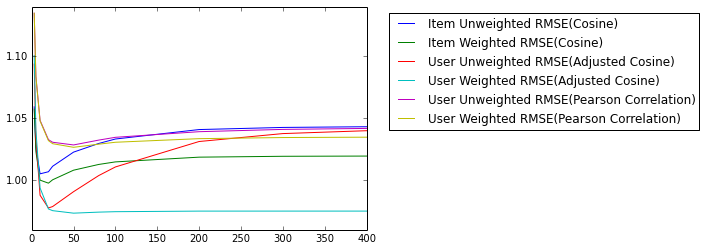

In [84]:
plt.plot([3,5,10,20,25,50,80,100,200,300,400],item_unknn_rmse,label='Item Unweighted RMSE(Cosine)')
plt.plot([3,5,10,20,25,50,80,100,200,300,400],item_wknn_rmse,label='Item Weighted RMSE(Cosine)')
plt.plot([3,5,10,20,25,50,80,100,200,300,400],user_adj1_rmse,label='User Unweighted RMSE(Adjusted Cosine)')
plt.plot([3,5,10,20,25,50,80,100,200,300,400],user_adj2_rmse,label='User Weighted RMSE(Adjusted Cosine)')
plt.plot([3,5,10,20,25,50,80,100,200,300,400],user_unknn_rmse,label='User Unweighted RMSE(Pearson Correlation)')
plt.plot([3,5,10,20,25,50,80,100,200,300,400],user_wknn_rmse,label='User Weighted RMSE(Pearson Correlation)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [133]:
m = np.array(m,dtype=float)

In [161]:
pred3 = np.zeros(len(testdf))
for k in [200]:
    for i,item in enumerate(testdf.iterrows()):
        item = item[1]
        user = item[0]
        movie = item[1]
        index = pd.notnull(m[user])
        train_y = m[user][index]
        train_x = m.loc[index]
        test_x = m.loc[movie]
        pred3[i] = knn_imp(train_x,train_y,test_x,k)
        

In [162]:
pred3[np.isnan(pred3)]=global_av
print mean_squared_error(test_y,pred3)**0.5

1.54432725712


weighted item based
k = 1,3,5,10,15,20,25,50     
1.49079892749   
1.21362493424   
1.14229869195    
1.12560730658    
1.19329053212   
1.2416252918   
1.27061276955   
1.36583396992

user-based unweighted knn:     
k=1 1.6700142669  
k=3 1.40377137599  
k=5 1.3423389031  
k=10 1.28925503918  
k=15 1.27249989558  
k=20 1.26164631112  
k=25 1.25401005602  
k=50 1.23756805347  

In [183]:
userdf.head()

,0,1,2,3,4
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [219]:
from sklearn.preprocessing import normalize
# userdf[0]-=1
# print min(userdf[2]),max(userdf[2])
# userdf[2] = (userdf[2]-min(userdf[2]))/(max(userdf[2])-min(userdf[2]))
# age=[1,18,25,35,45,50,56]
# categories=[1,2,3,4,5,6,7]
# age_dict = dict(zip(age,categories))
# userdf[2] = map(lambda x:age_dict[x],userdf[2])
userdf[1]=normalize(userdf[1])[0]
# userdf = pd.concat([userdf,pd.get_dummies(userdf[2],prefix='age')],axis=1)
# userdf = userdf.drop(2,axis=1)
# userdf[4] = userdf[4].str[:1]
# print userdf[4]
# userdf = pd.concat([userdf,pd.get_dummies(userdf[2],prefix='age')],axis=1)
# userdf = userdf.drop(2,axis=1)
userdf = pd.concat([userdf,pd.get_dummies(userdf[2],prefix='gender')],axis=1)
userdf = userdf.drop(2,axis=1)
userdf = pd.concat([userdf,pd.get_dummies(userdf[3],prefix='occ_')],axis=1)
userdf = userdf.drop(3,axis=1)
# userdf = pd.concat([userdf,pd.get_dummies(userdf[4],prefix='zip_code')],axis=1)
userdf = userdf.drop(4,axis=1)
print userdf.head()
print userdf.shape

   0         1  gender_F  gender_M  occ__administrator  occ__artist  \
0  1  0.021609       0.0       1.0                 0.0          0.0   
1  2  0.047721       1.0       0.0                 0.0          0.0   
2  3  0.020709       0.0       1.0                 0.0          0.0   
3  4  0.021609       0.0       1.0                 0.0          0.0   
4  5  0.029713       1.0       0.0                 0.0          0.0   

   occ__doctor  occ__educator  occ__engineer  occ__entertainment     ...       \
0          0.0            0.0            0.0                 0.0     ...        
1          0.0            0.0            0.0                 0.0     ...        
2          0.0            0.0            0.0                 0.0     ...        
3          0.0            0.0            0.0                 0.0     ...        
4          0.0            0.0            0.0                 0.0     ...        

   occ__marketing  occ__none  occ__other  occ__programmer  occ__retired  \
0          

/Users/Jiayu/Library/Python/2.7/lib/python/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [220]:
userdf.head()

,0,1,gender_F,gender_M,occ__administrator,occ__artist,occ__doctor,occ__educator,occ__engineer,occ__entertainment,...,occ__marketing,occ__none,occ__other,occ__programmer,occ__retired,occ__salesman,occ__scientist,occ__student,occ__technician,occ__writer
0,1,0.021609,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.047721,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.020709,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,0.021609,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,0.029713,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [190]:
moviedf.head()

,1,2,3,4,5,6,7,8,9,10,...,14,15,16,17,18,19,20,21,22,23
0,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [221]:
# moviedf = moviedf.drop(0,axis=0)
moviedf = moviedf.drop([3,4],axis=1)

In [222]:
import re
pat = re.compile("\(([0-9]+)\)")
moviedf['year'] = np.zeros(len(moviedf))
for i,s in enumerate(moviedf[1]):
    if pat.search(s): moviedf['year'].loc[i+1]=(int(pat.search(s).group(1)[2:])-1)/10
# years = [(int(pat.search(s).group(1)[2:])-1)/10 for s in moviedf[1]]
# years = [9 if x==-1 else x for x in years]
# moviedf['year'] = years
# moviedf = pd.concat([moviedf,pd.get_dummies(moviedf['year'],prefix='year')],axis=1)
# moviedf = moviedf.drop('year',axis=1)
# moviedf.tail()

In [223]:
print moviedf.tail()
print userdf.shape,moviedf.shape

                                              1            2  5  6  7  8  9  \
0                                                                             
1678                          Mat' i syn (1997)  06-Feb-1998  0  0  0  0  0   
1679                           B. Monkey (1998)  06-Feb-1998  0  0  0  0  0   
1680                       Sliding Doors (1998)  01-Jan-1998  0  0  0  0  0   
1681                        You So Crazy (1994)  01-Jan-1994  0  0  0  0  0   
1682  Scream of Stone (Schrei aus Stein) (1991)  08-Mar-1996  0  0  0  0  0   

      10  11  12  ...   15  16  17  18  19  20  21  22  23  year  
0                 ...                                             
1678   0   0   0  ...    0   0   0   0   0   0   0   0   0   9.0  
1679   0   0   0  ...    0   0   0   0   1   0   1   0   0   9.0  
1680   0   0   0  ...    0   0   0   0   1   0   0   0   0   9.0  
1681   1   0   0  ...    0   0   0   0   0   0   0   0   0   9.0  
1682   0   0   0  ...    0   0   0   0   0  

In [228]:
train_x = np.zeros((len(traindf),43))
test_x = np.zeros((len(testdf),43))
train_y = traindf[2]
test_y = testdf[2]
for i in range(len(traindf)):
    userid = int(traindf.loc[i][0])-1
    movieid = int(traindf.loc[i][1])
    train_x[i] = np.concatenate([userdf.loc[userid][2:],moviedf.loc[movieid][2:]])

for i in range(len(testdf)):
    userid = int(testdf.loc[i][0])-1
    movieid = int(testdf.loc[i][1])
    test_x[i] = np.concatenate([userdf.loc[userid][2:],moviedf.loc[movieid][2:]])


In [232]:
import xgboost as xgb
train_rmse = np.zeros(20)
test_rmse = np.zeros(20)
n = [1000,1500,2000]
lr = [0.05,0.1,0.3,0.5,0.8]
i = 0
for estimator in n:
    for gamma in lr:
        print estimator,gamma
        xgbtree=xgb.XGBRegressor(n_estimators=estimator,learning_rate=gamma)
        xgbtree.fit(train_x,train_y)
        train_rmse[i] = mean_squared_error(train_y,xgbtree.predict(train_x))**0.5
        test_rmse[i] = mean_squared_error(test_y,xgbtree.predict(test_x))**0.5
        print i,train_rmse[i],test_rmse[i]
        i+=1

1000 0.05
0 1.05138639689 1.07737422605
1000 0.1
1 1.04353735725 1.07292649494
1000 0.3
2 1.03426262633 1.06996977482
1000 0.5
3 1.03006092394 1.06992306398
1000 0.8
4 1.02659466937 1.07222583751
1500 0.05
5 1.04747299499 1.07521435973
1500 0.1
6 1.04016958072 1.07163341653
1500 0.3
7 1.03146646269 1.06976632067
1500 0.5
8 1.02734926923 1.07102405251
1500 0.8
9 1.0237268464 1.07299308948
2000 0.05
10 1.04461486315 1.07361615081
2000 0.1
11 1.03799786763 1.07081597312
2000 0.3
12 1.02942620362 1.06971275125
2000 0.5
13 1.02538602349 1.07141734322
2000 0.8
14 1.02195278119 1.07370775603


In [ ]:
from scipy.stats import pearsonr
def knn_imp(train_x,train_y,test_x,k):
    train_x = np.array(train_x,dtype=float)
    train_y = np.array(train_y,dtype=float)
    test_x = np.array(test_x,dtype=float)
    sim = np.zeros(len(train_y))
    for i,row in enumerate(train_x):
        sim[i]=pearson(test_x,row)
#     print sim
    index = sim.argsort()[-1*k:]
    s = sim[index]
    r = train_y[index]
    return np.dot(s,r)/np.sum(np.absolute(s))
#     return (train_y[sim.argsort()[-1*k:]]*1.0).mean()